Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

Step 4: Fit a wavelength solution to the lamp composite. 

Step 5: Extract the 1-D spectrum and its wavelength solution.

**Step 6: Apply a relative flux calibration.**

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from matplotlib import pyplot as plt 

from astropy import units as u
from astropy import constants
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.polynomial import Polynomial1D
from astropy.io import ascii
from astropy.table import Table

from scipy.interpolate import UnivariateSpline

### (0) read in the data 

In [2]:
path = '/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/sandbox/'

# reduced, wavelength calibrated 1D spectrum 
spec = np.load(path+'regulus_spec.npy')
wave = np.load(path+'regulus_wave.npy')

regulus_hdr = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/regulus.fits')[0].header

# (6) flux calibration

Flux calibration in spectroscopy is much like flux calibration for images: observe a star of known flux, then use this to determine the scale factor to convert from counts to flux. The key difference is that we do this as a function of wavelength. Instead of comparing one number at one wavelength, we'll derive a correction that is a function of the wavelength. 

In this notebook, the flux standard is Regulus. 

Text(0, 0.5, 'counts')

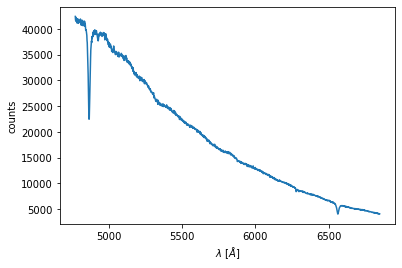

In [3]:
plt.plot(wave, spec)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('counts')

Start by gathering the data for the standard star. These data are available within some software packages (like IRAF) and as standalone tables. We want the file 'hr3982' (another name for Regulus - you can check this by looking the object up on Simbad). 

This table has three columns: the wavelength (in Angstrom), the magnitude (AB magnitude), and the width of the bandpass. 

In [4]:
# the 3 columns in the file are: wavelength (Angstrom), magnitude, bandpass
std_dat = Table.read('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/hr3982.dat', format='ascii', 
                    names=['wave','mag','bp'])

In [5]:
std_dat.pprint()

 wave   mag   bp 
------ ----- ----
3200.0 1.856 49.0
3250.0 1.856 49.0
3300.0 1.856 49.0
3350.0 1.856 49.0
3400.0 1.855 49.0
3450.0 1.859 49.0
3500.0 1.854 49.0
   ...   ...  ...
6436.0  1.56 98.0
6790.0  1.62 98.0
7100.0 1.679 98.0
7550.0  1.78 98.0
7780.0 1.816 98.0
8090.0 1.861 98.0
8370.0 1.902 98.0
Length = 29 rows


First, convert the observed magnitudes to fluxes. 

The magnitudes given for the standard star are AB magnitudes (see, e.g., https://lweb.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html for more information on magnitude systems). AB mags are defined as 

$m_{\mathrm{AB}} = -2.5 \log_{10}(f_{\nu}) - 48.60$

where the fluxes are in units erg/s/cm$^2$/Hz. Notice that the flux is per unit frequency, not per unit wavelength! For monochromatic flux, $m_{\mathrm{AB}} = V$. 

In [6]:
# use astropy units to keep track of the units 
zero_pt = 48.60 # AB mag system
fnd_flx = 10.**((std_dat['mag'] + zero_pt) / (-2.5)) * u.erg * u.cm**-2 * u.s**-1 * u.Hz**-1

Recall, the instrumental magnitude is 

$m_{\mathrm{instr}} = -2.5 \log_{10}(N_{\mathrm{counts}}/t_{\mathrm{exp}})$

Same idea as flux calibrating images: 

$m_{\mathrm{calib}} = m_{\mathrm{instr}} + m_{\mathrm{zp}}$ 

where we derive the zeropoint by comparing with a star of known flux 

$m_{\mathrm{std}} - m_{\mathrm{std,i}} = m_{\mathrm{zp}}$ 

As in IRAF, https://iraf.readthedocs.io/en/latest/tasks/noao/imred/irs/sensfunc.html, we will compute the calibration factor at each point as

C = 2.5 log (O / (T B F))

where O is the observed counts in the bandpass, T is the exposure time, B is the bandpass width, F is the flux **per Angstrom** at the bandpass for the standard star. The ratio C is the observed count rate per Angstrom over the expected flux expressed in magnitudes. 



First, we computed the fluxes of the standard star in erg/s/cm^2/**Hz** but we want to measured fluxes in erg/s/cm^2/**Angstrom**. So we need to do a little unit conversion. 

In [7]:
# freq = c / lambda 
freq = (constants.c / (std_dat['wave'] * u.Angstrom)).to(u.Hz)

In [8]:
std_flx = fnd_flx * freq / (std_dat['wave'] * u.Angstrom)

In [9]:
std_flx

<Quantity [1.92362648e-09, 1.86489327e-09, 1.80880947e-09, 1.75521810e-09,
           1.70554377e-09, 1.65037453e-09, 1.61095947e-09, 1.54611218e-09,
           1.50235634e-09, 1.51732547e-09, 2.72393139e-09, 2.70718782e-09,
           2.45682205e-09, 2.30473806e-09, 2.02195894e-09, 1.86101078e-09,
           1.60789179e-09, 1.38701352e-09, 1.17369151e-09, 9.94709415e-10,
           8.47998353e-10, 7.51015620e-10, 6.24580804e-10, 5.30983657e-10,
           4.59942991e-10, 3.70618249e-10, 3.37645922e-10, 2.99587480e-10,
           2.69506837e-10] erg / (Angstrom cm2 s)>

In [10]:
std_flx.unit

Unit("erg / (Angstrom cm2 s)")

Now, compute the average counts in the observed spectrum in the same bandpasses. Why the average? 

First, we need to select the points that correspond to the spectral range we observed. 

In [11]:
in_spec = np.where(((std_dat['wave']-std_dat['bp']) > wave.min()) & ((std_dat['wave']+std_dat['bp']) < wave.max()))

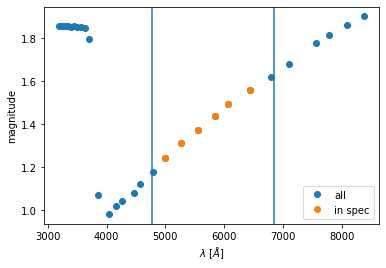

In [14]:
plt.plot(std_dat['wave'], std_dat['mag'], 'o')
plt.plot(std_dat['wave'][in_spec], std_dat['mag'][in_spec], 'o')
plt.legend(['all', 'in spec'])
plt.xlabel('$\\lambda$ [$\\AA$]')
plt.ylabel('magnitude')

plt.axvline(wave.min())
plt.axvline(wave.max())

In [15]:
ave_counts = []

for cntr, wid in zip(std_dat['wave'][in_spec], std_dat['bp'][in_spec]):
    in_bp = np.where((wave > (cntr-wid)) & (wave < (cntr+wid)))
    ave_counts.append(np.nanmean(spec[in_bp]))

In [16]:
obj_flux = (np.array(ave_counts) / regulus_hdr['EXPTIME'])

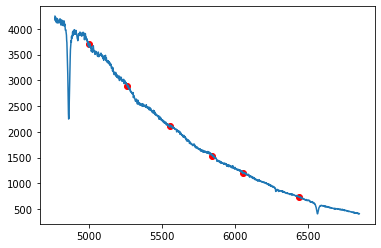

In [17]:
# check the average
plt.plot(wave, spec/regulus_hdr['EXPTIME'])
plt.scatter(std_dat['wave'][in_spec], obj_flux, color='red')

In [18]:
# the ratio between the standard star flux and observed flux 
# check to make sure the units are erg/count ! 

ratio = np.abs(np.array(std_flx[in_spec],dtype='float') / 
               np.array(obj_flux,dtype='float'))

In [19]:
# fit the log of the ratio - mag units!
LogSensfunc = np.log10(ratio)

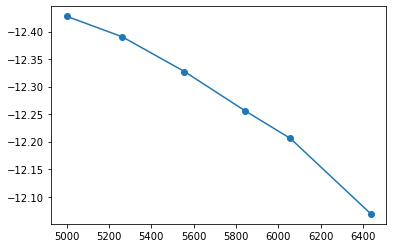

In [20]:
plt.plot(std_dat['wave'][in_spec], LogSensfunc, '-o')
# invert the scaling of the y-axis since these are magnitudes 
plt.gca().invert_yaxis()

In [21]:
# interpolate back onto observed wavelength grid
# try and compare a few different functions

# linear 
sensfunc2_linear = 10**np.interp(wave, std_dat['wave'][in_spec], LogSensfunc)

# spline 
spl = UnivariateSpline(std_dat['wave'][in_spec], LogSensfunc, ext=0, k=3, s=0.005)
sensfunc2_spline = 10**spl(wave)

# poly
polydeg = 3
fit = np.polyfit(std_dat['wave'][in_spec], LogSensfunc, polydeg)
sensfunc2_poly = 10**np.polyval(fit, wave)


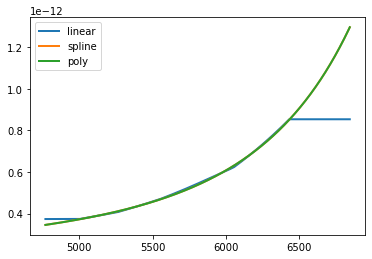

In [22]:
plt.plot(wave, sensfunc2_linear, lw=2)
plt.plot(wave, sensfunc2_spline, lw=2)
plt.plot(wave, sensfunc2_poly, lw=2)
plt.legend(['linear', 'spline', 'poly'])

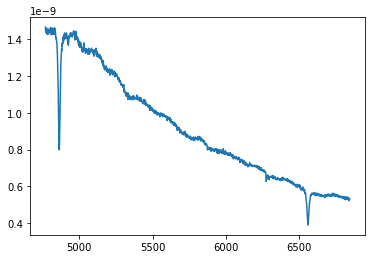

In [23]:
plt.plot(wave, (spec/regulus_hdr['EXPTIME'])*sensfunc2_spline)

If you are satisfied with the flux calibration (how can you check that everything went well??), then apply the correction to the target spectra. Be sure to save the flux-calibrated result. 